In [1]:
!pip install tensorflow keras matplotlib scikit-learn


In [2]:
from google.colab import files
uploaded = files.upload()  # upload your kaggle.json here


Saving kaggle.json to kaggle.json


In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
!kaggle datasets list | head


ref                                                    title                                          size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ---------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmadrazakashif/bmw-worldwide-sales-records-20102024   BMW Worldwide Sales Records (2010–2024)      853348  2025-09-20 14:39:45.280000           7468        161  1.0              
jockeroika/life-style-data                             Life Style Data                             6289184  2025-10-13 02:11:38.793000           1855         53  0.9411765        
anassarfraz13/coffee-sales-dataset                     Coffee Sales Dataset                          38970  2025-09-23 09:50:57.187000           2765         64  1.0              
grandmaster07/student-exam-score-dataset-analysis      Student exam score dataset analysis          

In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [03:21<00:01, 13.6MB/s]
100% 5.20G/5.20G [03:26<00:00, 27.0MB/s]


In [6]:
!ls /content


ham10000_images_part_1	HAM10000_metadata.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_1	hmnist_28_28_L.csv     kaggle.json
ham10000_images_part_2	hmnist_28_28_RGB.csv   sample_data
HAM10000_images_part_2	hmnist_8_8_L.csv


In [7]:
import pandas as pd
import os, shutil
from glob import glob

# Load metadata
meta = pd.read_csv('/content/HAM10000_metadata.csv')

# Map to benign/malignant
malignant_classes = {'akiec','bcc','mel'}
meta['binary'] = meta['dx'].apply(lambda x: 'malignant' if x in malignant_classes else 'benign')

# Create output directories
base_dir = '/content/ham10000_binary'
os.makedirs(base_dir, exist_ok=True)
for label in ['benign', 'malignant']:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

# Collect all image files from both folders
image_paths = glob('/content/HAM10000_images_part_1/*.jpg') + glob('/content/HAM10000_images_part_2/*.jpg')
image_dict = {os.path.basename(p).split('.')[0]: p for p in image_paths}

# Copy images into new folders
missing = []
for _, row in meta.iterrows():
    img_id = row['image_id']
    label = row['binary']
    if img_id in image_dict:
        src = image_dict[img_id]
        dst = os.path.join(base_dir, label, os.path.basename(src))
        shutil.copy(src, dst)
    else:
        missing.append(img_id)

print(f"Copied {len(meta)-len(missing)} images into folders.")
print(f"Missing images: {len(missing)}")


Copied 10015 images into folders.
Missing images: 0


In [8]:
for label in ['benign','malignant']:
    count = len(os.listdir(f'/content/ham10000_binary/{label}'))
    print(f"{label}: {count} images")


benign: 8061 images
malignant: 1954 images


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '/content/ham10000_binary',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/ham10000_binary',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 8013 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Load metadata
df = pd.read_csv("HAM10000_metadata.csv")
df['path'] = df['image_id'].apply(lambda x: os.path.join("ham10000_images_part_1", f"{x}.jpg")
                                  if os.path.exists(os.path.join("ham10000_images_part_1", f"{x}.jpg"))
                                  else os.path.join("ham10000_images_part_2", f"{x}.jpg"))

# Split into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create train and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the EfficientNetB0 base model (pretrained on ImageNet)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
num_classes = len(train_generator.class_indices)  # get number of classes
output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    verbose=1
)


Epoch 1/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 181s 721ms/step - accuracy: 0.6744 - loss: 1.1798 - val_accuracy: 0.6695 - val_loss: 1.1565
Epoch 2/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 563ms/step - accuracy: 0.6686 - loss: 1.1699 - val_accuracy: 0.6695 - val_loss: 1.1331
Epoch 3/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 144s 574ms/step - accuracy: 0.6687 - loss: 1.1722 - val_accuracy: 0.6695 - val_loss: 1.1313
Epoch 4/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 570ms/step - accuracy: 0.6743 - loss: 1.1618 - val_accuracy: 0.6695 - val_loss: 1.1405
Epoch 5/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 145s 579ms/step - accuracy: 0.6707 - loss: 1.1501 - val_accuracy: 0.6695 - val_loss: 1.1323
Epoch 6/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 572ms/step - accuracy: 0.6730 - loss: 1.1497 - val_accuracy: 0.6695 - val_loss: 1.1307
Epoch 7/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 565ms/step - accuracy: 0.6758 - loss: 1.1320 - val_accuracy: 0.6695 - val_loss: 1.1389


In [14]:
# Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    verbose=1
)


Epoch 1/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 202s 678ms/step - accuracy: 0.4900 - loss: 1.6077 - val_accuracy: 0.6695 - val_loss: 1.1843
Epoch 2/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 144s 573ms/step - accuracy: 0.6696 - loss: 1.1729 - val_accuracy: 0.6695 - val_loss: 1.1716
Epoch 3/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 568ms/step - accuracy: 0.6808 - loss: 1.1300 - val_accuracy: 0.6695 - val_loss: 1.1576
Epoch 4/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 567ms/step - accuracy: 0.6785 - loss: 1.1372 - val_accuracy: 0.6695 - val_loss: 1.1482
Epoch 5/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 566ms/step - accuracy: 0.6787 - loss: 1.1334 - val_accuracy: 0.6695 - val_loss: 1.1435
Epoch 6/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 598ms/step - accuracy: 0.6798 - loss: 1.1236 - val_accuracy: 0.6695 - val_loss: 1.1384
Epoch 7/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 568ms/step - accuracy: 0.6660 - loss: 1.1514 - val_accuracy: 0.6695 - val_loss: 1.1419


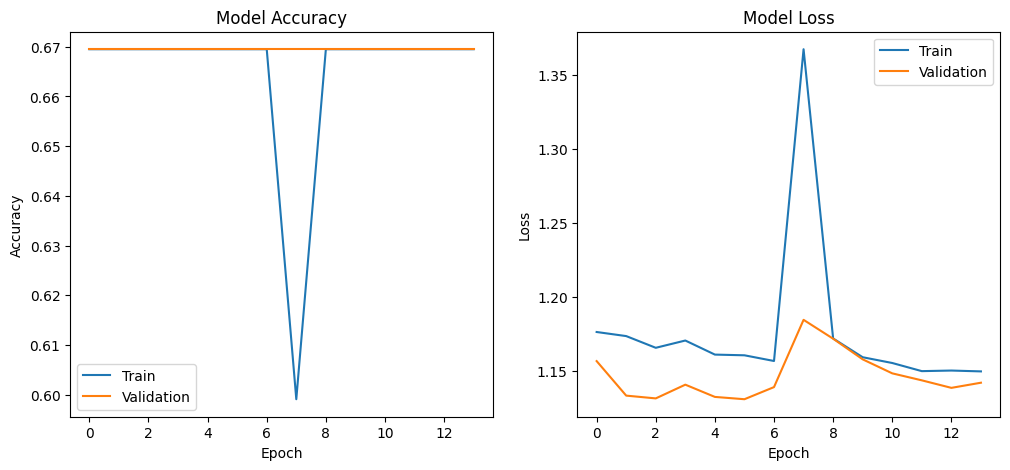

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_finetune.history['loss'])
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [16]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.3f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.6561 - loss: 1.1627
Validation Accuracy: 0.669


In [17]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


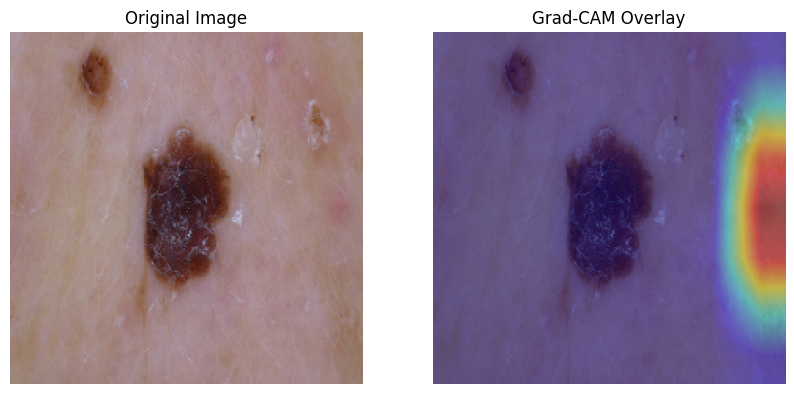

In [18]:
def get_gradcam(model, img_array, layer_name='top_conv'):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = np.zeros(conv_outputs.shape[1:3], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[0,:,:,i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)  # normalize
    return cam  # already numpy array

#  Pick a sample image from validation generator
sample_img, _ = next(val_generator)
img = sample_img[0]
img_array = np.expand_dims(img, axis=0)

#  Compute Grad-CAM
cam = get_gradcam(model, img_array, layer_name='top_conv')

#  Resize CAM & Overlay
cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
superimposed = cv2.addWeighted((img*255).astype(np.uint8), 0.6, heatmap, 0.4, 0)

#  Plot Grad-CAM Overlay
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(superimposed)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()

In [19]:
model.save('efficientnet_skin_lesion_model.h5')
